In [32]:
# pip install pandas numpy tensorflow scikit-learn matplotlib tqdm
# !pip3 install scikeras


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.layers import SimpleRNN, Dense, Dropout

from sklearn.inspection import permutation_importance


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Load the dataset
file_path = '/Users/pvuda/Documents/features/combined_file.csv'
data = pd.read_csv(file_path)

In [5]:
# Display the first few rows of the dataframe
display(data.head())
print("Features:", data.columns.to_list())
print("Class of real_or_fake:", set(data['real_or_fake']))

,audio_id,real_or_fake,spectral_centroid_mean,spectral_centroid_std,spectral_centroid_var,spectral_centroid_min,spectral_centroid_max,spectral_centroid_range,spectral_centroid_25th_percentile,spectral_centroid_50th_percentile,...,shimmer_dda,hnr,voicedcount,npause,originaldur,intensity_duration,speakingrate,articulationrate,asd,totalpauseduration
0,p241_171,F02,1264.074015,822.964906,677271.236891,422.119966,4438.950839,4016.830872,750.791935,1028.198334,...,0.118602,10.488762,13.0,0.0,4.140000,4.140000,3.140097,5.416667,0.184615,1.740000
1,p241_171,F06,1092.732243,835.096515,697386.189558,299.390288,4276.826478,3977.436190,569.495673,859.165036,...,0.120658,11.283641,14.0,0.0,4.160000,4.160000,3.365385,5.794702,0.172571,1.744000
2,p241_171,F01,1239.497052,842.612526,709995.868275,288.564361,4151.701698,3863.137337,764.123650,1024.689694,...,0.125836,10.476980,14.0,0.0,3.474125,3.474125,4.029792,5.570892,0.179504,0.961063
3,p241_171,F05,1218.714047,851.013722,724224.354809,384.025330,4499.744355,4115.719024,723.722157,988.215478,...,0.136116,9.717817,12.0,0.0,4.143750,4.143750,2.895928,5.000000,0.200000,1.743750
4,p241_171,F04,1090.133359,872.704547,761613.225871,206.065685,4304.859443,4098.793758,531.764632,867.988671,...,0.186246,8.789596,14.0,0.0,4.146667,4.146667,3.376206,5.756579,0.173714,1.714667


Features: ['audio_id', 'real_or_fake', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_centroid_var', 'spectral_centroid_min', 'spectral_centroid_max', 'spectral_centroid_range', 'spectral_centroid_25th_percentile', 'spectral_centroid_50th_percentile', 'spectral_centroid_75th_percentile', 'spectral_centroid_skew', 'spectral_centroid_kurtosis', 'spectral_bandwidth_mean', 'spectral_bandwidth_std', 'spectral_bandwidth_var', 'spectral_bandwidth_min', 'spectral_bandwidth_max', 'spectral_bandwidth_range', 'spectral_bandwidth_25th_percentile', 'spectral_bandwidth_50th_percentile', 'spectral_bandwidth_75th_percentile', 'spectral_bandwidth_skew', 'spectral_bandwidth_kurtosis', 'spectral_contrast_mean', 'spectral_contrast_std', 'spectral_contrast_var', 'spectral_contrast_min', 'spectral_contrast_max', 'spectral_contrast_range', 'spectral_contrast_25th_percentile', 'spectral_contrast_50th_percentile', 'spectral_contrast_75th_percentile', 'spectral_contrast_skew', 'spectral_contrast_k

In [6]:
data['real_or_fake_general'] = data['real_or_fake'].apply(lambda x: 'R' if x.startswith('R') else 'F')
set(data['real_or_fake_general'])

{'F', 'R'}

In [7]:
label_encoder = LabelEncoder()
data['real_or_fake_general'] = label_encoder.fit_transform(data['real_or_fake_general'])
set(data['real_or_fake_general'])

{0, 1}

In [8]:
# # Convert 'real_or_fake' to numerical labels
# label_encoder = LabelEncoder()
# data['real_or_fake'] = label_encoder.fit_transform(data['real_or_fake'])

In [9]:
# Define features and target
X = data.drop(columns=['audio_id', 'real_or_fake', 'real_or_fake_general'])
y = data['real_or_fake_general']

In [10]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [12]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## SimpleRNN

In [13]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
history = model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8587 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 2/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 158s 23ms/step - accuracy: 0.8593 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 3/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8578 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 4/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8595 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 5/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8595 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 6/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8586 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 7/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 158s 23ms/step - accuracy: 0.8586 - loss: nan - val_accuracy: 0.8596 - val_loss: nan
Epoch 8/20
6787/6787 ━━━━━━━━━━━━━━━━━━━━ 159s 23ms/step - accuracy: 0.8586 - loss: nan - val_accuracy: 0.8596 

In [27]:
# Make predictions
nn_predictions_prob = model.predict(X_test)
nn_predictions = np.argmax(nn_predictions_prob, axis=1)  # Get the index of the highest probability

# Evaluate the model
accuracy = accuracy_score(y_test, nn_predictions)
print("Neural Network Accuracy: ", accuracy)
print(classification_report(y_test, nn_predictions, target_names=label_encoder.classes_))


1697/1697 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
Neural Network Accuracy:  0.8595634957178377
              precision    recall  f1-score   support

           F       0.86      1.00      0.92     46670
           R       0.00      0.00      0.00      7625

    accuracy                           0.86     54295
   macro avg       0.43      0.50      0.46     54295
weighted avg       0.74      0.86      0.79     54295



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [37]:
def custom_scorer(estimator, X, y):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    predictions = estimator.predict(X_reshaped)
    predictions = (predictions > 0.5).astype(int)
    return accuracy_score(y, predictions)

In [38]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring=custom_scorer)


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
# Get feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

1697/1697 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8607 - loss: nan
Test Accuracy: 85.96%


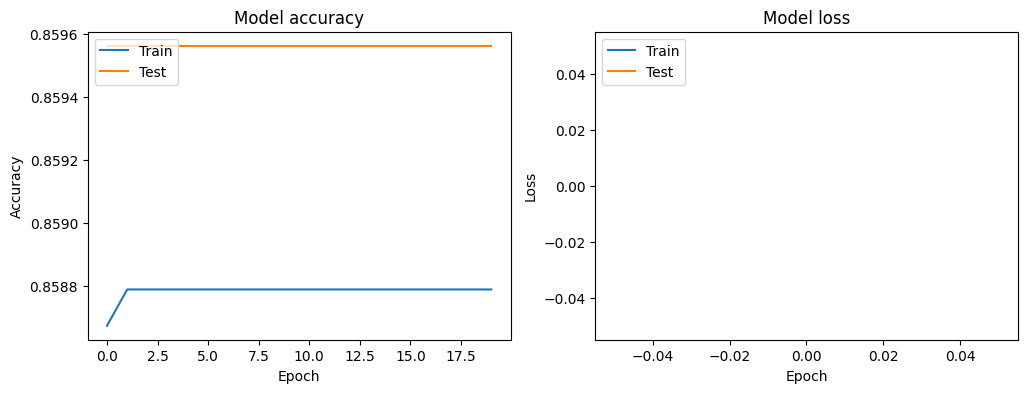

In [15]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## LSTM

In [39]:
# Define the RNN model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
lstm_model.summary()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 408, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 408, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,098 (453.51 KB)

 Trainable params: 116,098 (453.51 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
print(X_train_reshaped.shape)
print(y_train.shape)
print(X_test_reshaped.shape)
print(y_test.shape)

(217180, 408, 1)
(217180,)
(54295, 408, 1)
(54295,)


In [44]:
history = lstm_model.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=2, batch_size=32, verbose=1)

Epoch 1/2


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 2)

In [ ]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [ ]:
# Function to create the model
def create_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [2],
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Perform hyperparameter tuning using RandomizedSearchCV
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3, verbose=2)
grid_result = grid.fit(X_train_reshaped, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")

# Evaluate the model on the test set
best_model = grid_result.best_estimator_
y_pred_cat = best_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_cat, axis=1)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plotting accuracy and loss
import matplotlib.pyplot as plt

history = grid_result.best_estimator_.fit(X_train_reshaped, y_train, validation_data=(X_test_reshaped, y_test), epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'], verbose=0)
